In [1]:
from sklearn.model_selection import RepeatedKFold
import catboost
from catboost import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from bayes_opt import BayesianOptimization
import shap
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import *
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error  # Ensure this import is included
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# Configuring output figure format
%config InlineBackend.figure_format = 'svg'

In [3]:
# Making sure catboost is available
print(catboost.__version__)
!python --version

1.2.3
Python 3.9.18


In [4]:
# Set up decimal precision
np.set_printoptions(precision=4)

In [5]:
# Reading input dataset
ams,preds = pd.read_csv('ams_21.csv'), pd.read_csv('ams_21_preds.csv')

In [6]:
# This cell income = ams['income']...
income = ams['income']
id = preds['id']

In [7]:
# Normalising predictors
first_col = ams.iloc[:, 0]
remaining_cols = ams.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
ams = pd.concat([first_col, remaining_scaled], axis=1)



In [8]:
# Normalising predictors
first_col = preds.iloc[:, 0]
remaining_cols = preds.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
preds = pd.concat([first_col, remaining_scaled], axis=1)



In [9]:
# Preparing y and X
y = ams.income
X = preds.drop('id', axis=1)

In [10]:
dataset_dir = './inc_ams'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.

ams.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
preds.to_csv(
    os.path.join(dataset_dir, 'preds.csv'),
    index=False, sep=',', header=True
)

In [11]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(4275, 21)


Column names
dataset 1:
['colour_hue_disorderliness_mean', 'colour_hue_coherence_mean', 'colour_hue_contrast_std', 'surface_volume_disorderliness_mean', 'tcap_wetness_mean', 'ndwi_wetness_contrast_mean', 'tcap_wetness_disorderliness_mean', 'ndwi_wetness_coherence_std', 'tcap_wetness_coherence_mean', 'tcap_built_coherence_std', 'tcap_built_disorderliness_std', 'colour_brightness_coherence_mean', 'colour_brightness_disorderliness_mean', 'colour_saturation_mean', 'surface_structure_disorderliness_mean', 'tcap_greenness_std', 'tcap_greenness_contrast_mean', 'surface_structure_coherence_mean', 'surface_roughness_disorderliness_mean', 'x_coord', 'y_coord']


TBB Warning: The number of workers is currently limited to 5. The request for 39 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [12]:
# Cross-validation split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [13]:
# Create a CatBoost classifier instance
tuned_model = CatBoostClassifier(
    random_seed=64,
    iterations=1400,
    task_type="CPU",
    learning_rate=0.04,
    l2_leaf_reg=14,
    depth=2,
    loss_function='MultiClass'
)

# Fit the model
tuned_model.fit(
    X_train, y_train,
    verbose=False,
    eval_set=(X_validation, y_validation),
    early_stopping_rounds=50,  # Stops if the chosen metric doesn't improve in 50 rounds
    plot=False  # Plots the metric during training
)

# Get results of the evaluation
results = tuned_model.get_evals_result()

In [14]:
# Define the model with optimal parameters
tuned_model = CatBoostClassifier(
    random_seed=64,
    iterations=1400,
    task_type="CPU",
    learning_rate=0.04,
    l2_leaf_reg=14,
    depth=2,
    loss_function='MultiClass'
)

# Setup Repeated K-Fold cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# Prepare lists to store results
train_accuracy_results = []
test_accuracy_results = []
train_f1_results = []
test_f1_results = []
train_auc_results = []
test_auc_results = []

# Loop over each fold
for train_index, test_index in rkf.split(X):
    train_pool = Pool(X.iloc[train_index], y.iloc[train_index])
    test_pool = Pool(X.iloc[test_index], y.iloc[test_index])

    # Fit model
    tuned_model.fit(train_pool, eval_set=test_pool, verbose=False)

    # Predict on train and test sets
    train_predictions = tuned_model.predict(train_pool)
    test_predictions = tuned_model.predict(test_pool)
    
    # Predict probabilities for AUC calculation
    train_probabilities = tuned_model.predict_proba(train_pool)
    test_probabilities = tuned_model.predict_proba(test_pool)

    # Calculate Accuracy
    train_accuracy = accuracy_score(y.iloc[train_index], train_predictions)
    test_accuracy = accuracy_score(y.iloc[test_index], test_predictions)
    train_accuracy_results.append(train_accuracy)
    test_accuracy_results.append(test_accuracy)

    # Calculate F1 Score (macro)
    train_f1 = f1_score(y.iloc[train_index], train_predictions, average='macro')
    test_f1 = f1_score(y.iloc[test_index], test_predictions, average='macro')
    train_f1_results.append(train_f1)
    test_f1_results.append(test_f1)

    # Calculate AUC (macro, multi_class='ovr')
    train_auc = roc_auc_score(y.iloc[train_index], train_probabilities, multi_class='ovr', average='macro')
    test_auc = roc_auc_score(y.iloc[test_index], test_probabilities, multi_class='ovr', average='macro')
    train_auc_results.append(train_auc)
    test_auc_results.append(test_auc)

# Calculate the average and standard deviation of metrics across all train and test folds
mean_train_accuracy = np.mean(train_accuracy_results)
std_train_accuracy = np.std(train_accuracy_results)
mean_test_accuracy = np.mean(test_accuracy_results)
std_test_accuracy = np.std(test_accuracy_results)

mean_train_f1 = np.mean(train_f1_results)
std_train_f1 = np.std(train_f1_results)
mean_test_f1 = np.mean(test_f1_results)
std_test_f1 = np.std(test_f1_results)

mean_train_auc = np.mean(train_auc_results)
std_train_auc = np.std(train_auc_results)
mean_test_auc = np.mean(test_auc_results)
std_test_auc = np.std(test_auc_results)

print("Average Train Accuracy:", mean_train_accuracy)
print("Train Accuracy Standard Deviation:", std_train_accuracy)
print("Average Test Accuracy:", mean_test_accuracy)
print("Test Accuracy Standard Deviation:", std_test_accuracy)
print("Average Train F1 Score:", mean_train_f1)
print("Train F1 Score Standard Deviation:", std_train_f1)
print("Average Test F1 Score:", mean_test_f1)
print("Test F1 Score Standard Deviation:", std_test_f1)
print("Average Train AUC:", mean_train_auc)
print("Train AUC Standard Deviation:", std_train_auc)
print("Average Test AUC:", mean_test_auc)
print("Test AUC Standard Deviation:", std_test_auc)


Average Train Accuracy: 0.5403898635477583
Train Accuracy Standard Deviation: 0.003757989360173053
Average Test Accuracy: 0.44389863547758285
Test Accuracy Standard Deviation: 0.01545079951691559
Average Train F1 Score: 0.5088680920656079
Train F1 Score Standard Deviation: 0.004594801277146122
Average Test F1 Score: 0.4112904082530654
Test F1 Score Standard Deviation: 0.019874070857646642
Average Train AUC: 0.8231477500621406
Train AUC Standard Deviation: 0.0018144905661651258
Average Test AUC: 0.7488903580762184
Test AUC Standard Deviation: 0.01254686265866164


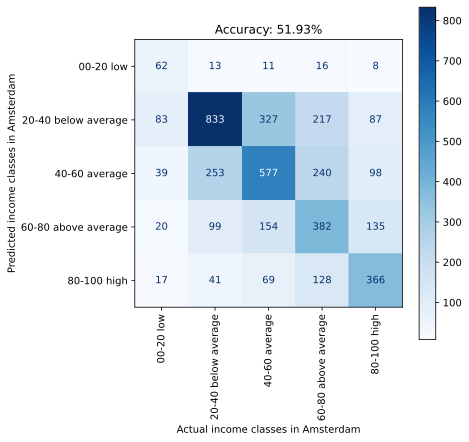

In [15]:
class_names = ['00-20 low', '20-40 below average', '40-60 average', '60-80 above average', '80-100 high']

# Ensure 'y' is a single-column DataFrame and convert it to a Series
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# Make predictions using the CatBoost model
predicted_values = tuned_model.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, predicted_values) * 100

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y, predicted_values, labels=class_names)

# Transpose the confusion matrix to swap axes
conf_matrix = conf_matrix.T

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)
ax.set_title(f'\nAccuracy: {accuracy:.2f}%')
ax.set_xlabel('Actual income classes in Amsterdam')
ax.set_ylabel('Predicted income classes in Amsterdam')

# Save the plot as an SVG file
plt.savefig('confusion_matrix_ams_21.svg', format='svg')

# Show the plot
plt.show()


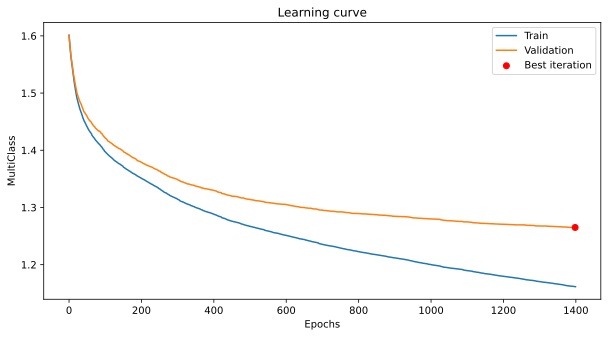

In [16]:
epochs = np.arange(len(results['learn']['MultiClass']))

# Retrieve the best iteration from the model
best_iteration = tuned_model.get_best_iteration()

plt.figure(figsize=(10, 5))
plt.plot(epochs, results['learn']['MultiClass'], label='Train')
plt.plot(epochs, results['validation']['MultiClass'], label='Validation')

# Mark the best iteration on the plot
if best_iteration is not None:
    plt.scatter(best_iteration, results['validation']['MultiClass'][best_iteration], color='red', zorder=5, label='Best iteration')

plt.xlabel('Epochs')
plt.ylabel('MultiClass')
plt.title('Learning curve')
plt.legend()
plt.show()


In [17]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(4275, 21)


Column names
dataset 1:
['colour_hue_disorderliness_mean', 'colour_hue_coherence_mean', 'colour_hue_contrast_std', 'surface_volume_disorderliness_mean', 'tcap_wetness_mean', 'ndwi_wetness_contrast_mean', 'tcap_wetness_disorderliness_mean', 'ndwi_wetness_coherence_std', 'tcap_wetness_coherence_mean', 'tcap_built_coherence_std', 'tcap_built_disorderliness_std', 'colour_brightness_coherence_mean', 'colour_brightness_disorderliness_mean', 'colour_saturation_mean', 'surface_structure_disorderliness_mean', 'tcap_greenness_std', 'tcap_greenness_contrast_mean', 'surface_structure_coherence_mean', 'surface_roughness_disorderliness_mean', 'x_coord', 'y_coord']


In [18]:
metrics = tuned_model.eval_metrics(
    data=pool1,
    metrics=['TotalF1','AUC', 'Accuracy'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=False
)

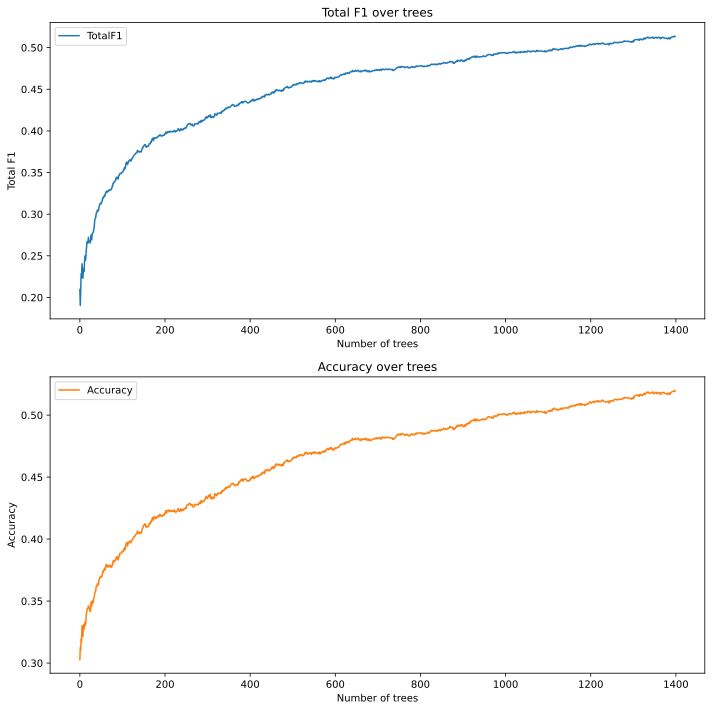

In [19]:
# Extracting metrics for plotting
multiclass_values = metrics['TotalF1']
f1_values = metrics['Accuracy']
trees = list(range(len(multiclass_values)))  # Assuming eval_period=1 and starting from the first tree

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting Multiclass
axs[0].plot(trees, multiclass_values, label='TotalF1', color='tab:blue')
axs[0].set_title('Total F1 over trees')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Total F1')
axs[0].legend()

# Plotting F1
axs[1].plot(trees, f1_values, label='Accuracy', color='tab:orange')
axs[1].set_title('Accuracy over trees')
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


In [20]:
# This cell tuned_model.get_feature_import...
tuned_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,y_coord,17.503981
1,x_coord,14.595033
2,colour_brightness_disorderliness_mean,9.672866
3,colour_hue_disorderliness_mean,5.682368
4,tcap_wetness_mean,5.580818
5,ndwi_wetness_contrast_mean,5.501708
6,tcap_greenness_contrast_mean,4.938641
7,colour_brightness_coherence_mean,4.425426
8,tcap_wetness_disorderliness_mean,3.591783
9,colour_hue_coherence_mean,3.353216


In [21]:
params = tuned_model.get_params()
params['loss_function'] = 'MultiClass'
params['custom_loss'] = 'TotalF1'


cv_data = cv(
    params = params,
    pool = Pool(X, label=y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=False,
    verbose=False
)

Training on fold [0/5]

bestTest = 1.258361613
bestIteration = 1398

Training on fold [1/5]

bestTest = 1.277652906
bestIteration = 1391

Training on fold [2/5]

bestTest = 1.272174842
bestIteration = 1399

Training on fold [3/5]

bestTest = 1.306038462
bestIteration = 1399

Training on fold [4/5]

bestTest = 1.291928262
bestIteration = 1397



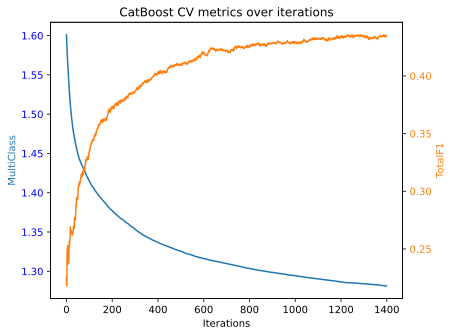

In [22]:
# Extracting the mean Multiclass and F1 values from cv_data
mean_multiclass = cv_data['test-MultiClass-mean']
mean_f1 = cv_data['test-TotalF1-mean']
iterations = range(len(mean_multiclass))

# Plotting the Multiclass and F1 values
fig, ax1 = plt.subplots()

ax1.set_xlabel('Iterations')
ax1.set_ylabel('MultiClass', color='tab:blue')
ax1.plot(iterations, mean_multiclass, label='MultiClass', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('TotalF1', color='tab:orange')
ax2.plot(iterations, mean_f1, label='TotalF1', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and legend
plt.title('CatBoost CV metrics over iterations')
fig.tight_layout()  # To ensure the right y-label is not clipped
plt.show()

In [23]:
multiclass_values = cv_data['train-MultiClass-mean']
f1_values = cv_data['train-TotalF1-mean']

# Create a DataFrame with both Multiclass and F1 values
cv_results_df = pd.DataFrame({'MultiClass': multiclass_values, 'TotalF1': f1_values})
cv_results_df

,MultiClass,TotalF1
0,1.600748,0.234979
1,1.593262,0.230355
2,1.586793,0.229262
3,1.579686,0.251304
4,1.572558,0.248748
...,...,...
1395,1.157157,0.533737
1396,1.157080,0.534099
1397,1.156924,0.535170
1398,1.156837,0.534635


In [24]:
multiclass_values = cv_data['test-MultiClass-mean']
f1_values = cv_data['test-TotalF1-mean']

# Create a DataFrame with both Multiclass and F1 values
cv_results_df = pd.DataFrame({'MultiClass': multiclass_values, 'TotalF1': f1_values})
cv_results_df

,MultiClass,TotalF1
0,1.600979,0.225503
1,1.593745,0.217923
2,1.587414,0.223419
3,1.580544,0.249191
4,1.573603,0.245948
...,...,...
1395,1.281440,0.434132
1396,1.281408,0.434563
1397,1.281358,0.434936
1398,1.281339,0.435081


In [25]:
shap_values = tuned_model.get_feature_importance(pool1, fstr_type='ShapValues')
print(shap_values.shape)

(4275, 5, 22)


In [26]:
explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer.shap_values(Pool(X, y))

#shap.initjs()
#shap.force_plot(explainer.expected_value[0],shap_values[0])

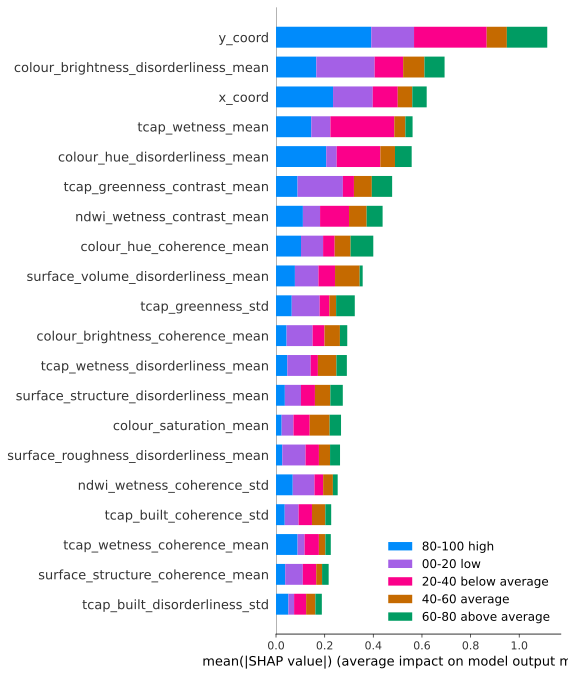

Text(0.5, 1.0, 'The Summary Plot for the Multiclass Model\nClass 2 - Best, Class 1 - Premium, Class 0 - Value')

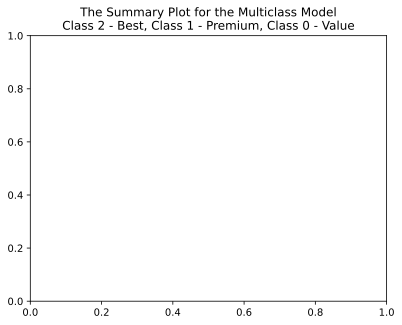

In [27]:
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)
plt.title('The Summary Plot for the Multiclass Model'+'\n'+'Class 2 - Best, Class 1 - Premium, Class 0 - Value')

In [28]:

labels = [
    "00-20 low",
    "20-40 below average",
    "40-60 average",
    "60-80 above average",
    "80-100 high",
]
le = LabelEncoder()
y = le.fit_transform(labels)
encoding_scheme = dict(zip(y, labels))
print(encoding_scheme)

{0: '00-20 low', 1: '20-40 below average', 2: '40-60 average', 3: '60-80 above average', 4: '80-100 high'}


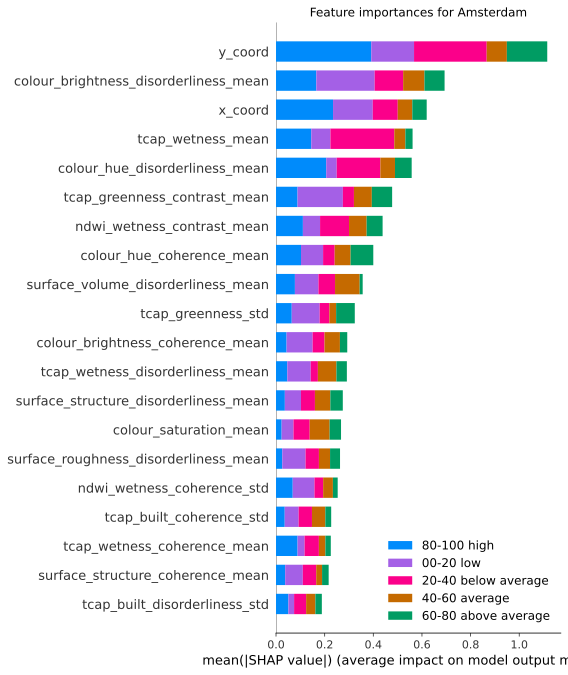

In [29]:
plt.title('Feature importances for Amsterdam')
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

In [30]:

plt.switch_backend('Agg')

# Set the title of the plot
plt.title('Impact on low income in Amsterdam')

# Generate SHAP summary plot
shap.summary_plot(shap_values[0], X.values, feature_names=X.columns, show=False)  # Set show=False to prevent immediate display

# After generating the plot, get the current figure
fig = plt.gcf()

# Save the current figure in SVG format
fig.savefig("shap_dependency_plot_lowAMS_21.svg", format='svg', bbox_inches='tight')

# Optionally, close the figure to free up memory
plt.close(fig)


In [31]:
plt.title('Impact on income below average in Amsterdam')
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

In [32]:
plt.title('Impact on average income in Amsterdam')
shap.summary_plot(shap_values[2], X.values, feature_names = X.columns)

In [33]:
plt.title('Impact on income above average in Amsterdam')
shap.summary_plot(shap_values[3], X.values, feature_names = X.columns)

In [34]:
plt.switch_backend('Agg')

# Set the title of the plot
plt.title('Impact on high income in Amsterdam')

# Generate SHAP summary plot
shap.summary_plot(shap_values[4], X.values, feature_names=X.columns, show=False)  # Set show=False to prevent immediate display

# After generating the plot, get the current figure
fig = plt.gcf()

# Save the current figure in SVG format
fig.savefig("shap_dependency_plot_highAMS_21.svg", format='svg', bbox_inches='tight')

plt.close(fig)


Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
